In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For model building
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# For time series analysis
import statsmodels.api as sm

In [2]:
#for visualization of our data we can set style for plots
sns.set_theme(style="whitegrid")
# Set random seed for reproducibility
np.random.seed(42)

1. Data Simulation
-------------------
Here we will simulate the data, but implementing actaul data from one's business would obviously be the best practice.

In [3]:
# Generate a date range (e.g., daily sales data for 3 years)
date_range = pd.date_range(start='2021-01-01', end='2023-12-31', freq='D')
n_days = len(date_range)

# Simulate sales data with seasonality and trend
trend = np.linspace(100, 500, n_days)  # Increasing trend over time
seasonality = 50 * np.sin(2 * np.pi * date_range.dayofyear / 365.25)  # Annual seasonality
noise = np.random.normal(0, 30, n_days)  # Random noise

# Simulated sales volume
sales = trend + seasonality + noise
sales = np.maximum(sales, 0)  # Ensure sales are non-negative

# Simulate marketing spend (monthly variability)
marketing_spend = np.random.uniform(1000, 5000, size=n_days)
marketing_spend = pd.Series(marketing_spend).rolling(window=30, min_periods=1).mean().values  # Smoothen

# Simulate economic indicator (e.g., consumer confidence index)
economic_indicator = 100 + np.random.normal(0, 5, n_days).cumsum()  # Cumulative sum to simulate trends


In [4]:
# Create DataFrame
data = pd.DataFrame({
    'Date': date_range,
    'Sales': sales,
    'Marketing_Spend': marketing_spend,
    'Economic_Indicator': economic_indicator
})

# Display first few rows
print("Simulated Sales Data:")
data.head()

Simulated Sales Data:


,Date,Sales,Marketing_Spend,Economic_Indicator
0,2021-01-01,115.761503,2264.624420,99.596417
1,2021-01-02,97.937605,2646.781827,109.381735
2,2021-01-03,122.741136,2153.285030,108.174663
3,2021-01-04,150.225558,2013.306974,112.934465
4,2021-01-05,98.733227,2599.949677,118.440244


2. Exploratory Data Analysis (EDA)
-----------------------------------

Let's take a quick peek at our data by exploring and visualize what we are working with

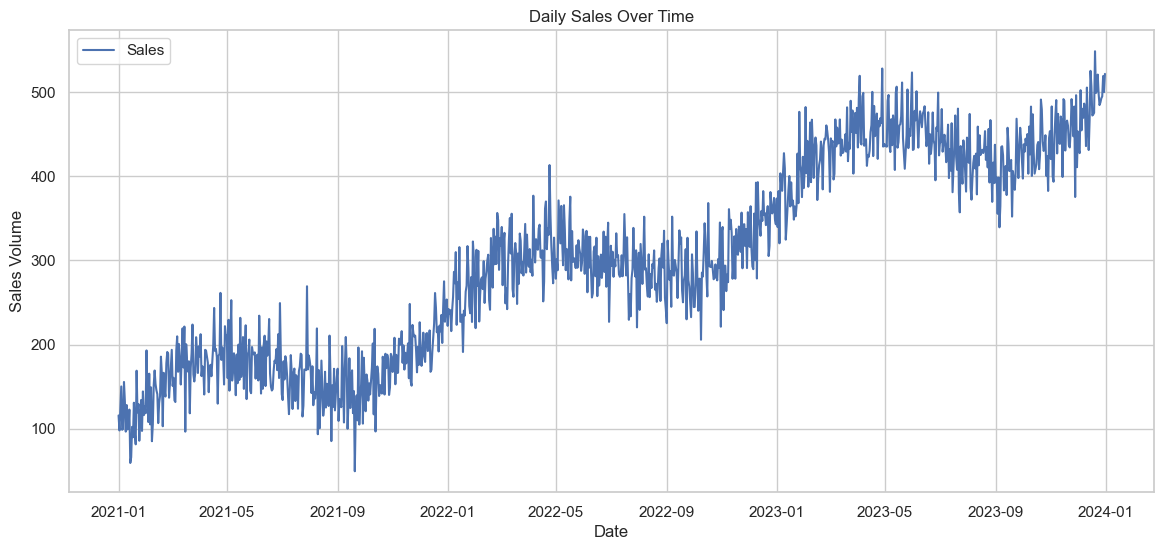

In [5]:
# Plot Sales Over Time
plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['Sales'], label='Sales')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.show()


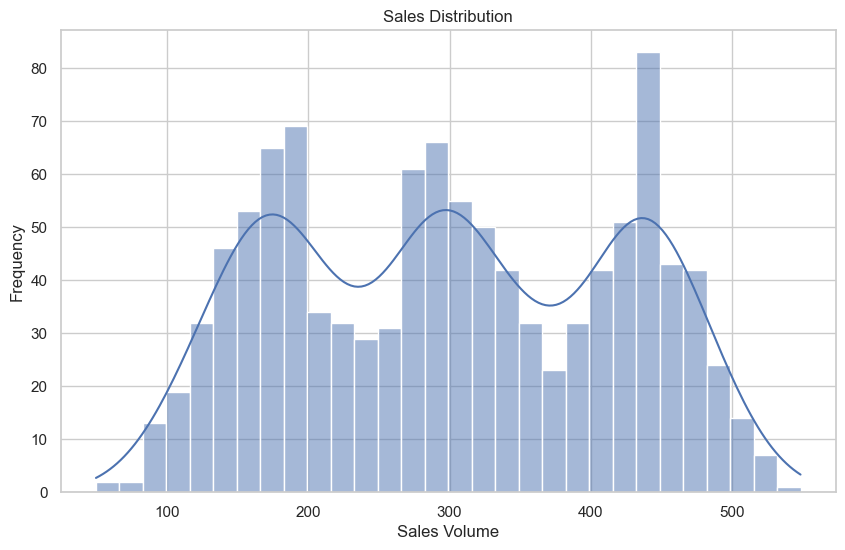

In [6]:
# Sales Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['Sales'], bins=30, kde=True)
plt.title('Sales Distribution')
plt.xlabel('Sales Volume')
plt.ylabel('Frequency')
plt.show()

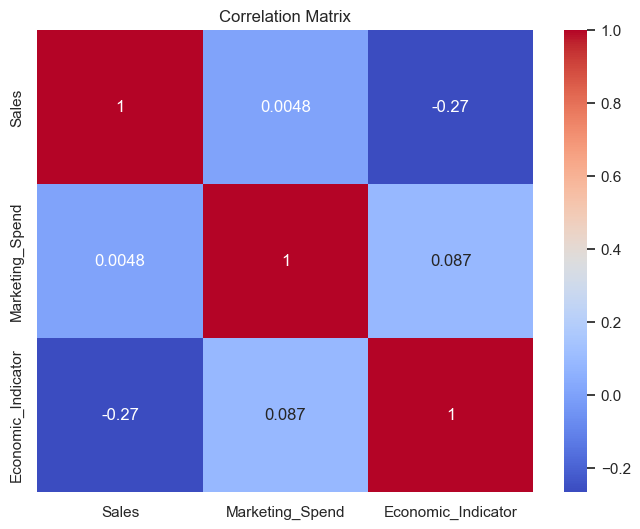

In [7]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data[['Sales', 'Marketing_Spend', 'Economic_Indicator']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

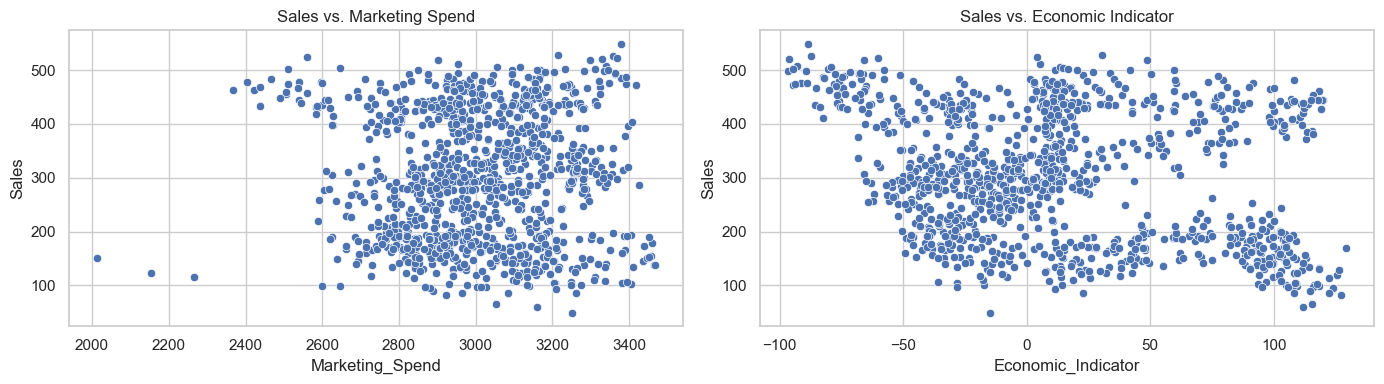

In [8]:
# Scatter Plots
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Marketing_Spend', y='Sales', data=data)
plt.title('Sales vs. Marketing Spend')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Economic_Indicator', y='Sales', data=data)
plt.title('Sales vs. Economic Indicator')

plt.tight_layout()
plt.show()

3. Feature Engineering
------------------------

We can now apply some feature engineering to the data to find the rolling averages

In [9]:
# Extract date features
data['Day_of_Week'] = data['Date'].dt.dayofweek
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

# Lag Features (e.g., sales from previous days)
data['Sales_Lag_1'] = data['Sales'].shift(1)
data['Sales_Lag_7'] = data['Sales'].shift(7)
data['Sales_Lag_30'] = data['Sales'].shift(30)

In [10]:
# Rolling Window Features
data['Sales_Rolling_Mean_7'] = data['Sales'].rolling(window=7).mean()
data['Sales_Rolling_Mean_30'] = data['Sales'].rolling(window=30).mean()

In [11]:
# Drop rows with NaN values due to lagging
data.dropna(inplace=True)
# Display updated data
print("\nData after Feature Engineering:")
data.head()


Data after Feature Engineering:


,Date,Sales,Marketing_Spend,Economic_Indicator,Day_of_Week,Month,Year,Sales_Lag_1,Sales_Lag_7,Sales_Lag_30,Sales_Rolling_Mean_7,Sales_Rolling_Mean_30
30,2021-01-31,118.335545,3156.999099,102.098464,6,1,2021,126.525885,85.728510,115.761503,121.437813,112.771954
31,2021-02-01,193.057613,3171.747423,102.249418,0,2,2021,118.335545,113.289949,97.937605,132.833193,115.942621
32,2021-02-02,138.179135,3282.058373,105.292455,1,2,2021,193.057613,134.093416,122.741136,133.416867,116.457221
33,2021-02-03,107.939553,3338.360579,102.976110,2,2,2021,138.179135,97.373838,150.225558,134.926255,115.047687
34,2021-02-04,165.425888,3210.861504,101.878891,3,2,2021,107.939553,144.305866,98.733227,137.943401,117.270776


4. Model Selection and Training
--------------------------------

Here we can select and train different models. We can use a Random Forest for this sales forcasting, but one could also use ARIMA, SARIMA, or Prophet for more time series forcasting. 

In [16]:
# Define features and target
features = ['Marketing_Spend', 'Economic_Indicator',
            'Day_of_Week', 'Month', 'Year',
            'Sales_Lag_1', 'Sales_Lag_7', 'Sales_Lag_30',
            'Sales_Rolling_Mean_7', 'Sales_Rolling_Mean_30']
target = 'Sales'

X = data[features]
y = data['Sales']

# Split data into training and testing sets (e.g., last 3 months as test)
train_size = int(len(data) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"\nTraining Data Size: {X_train.shape[0]} samples")
print(f"Testing Data Size: {X_test.shape[0]} samples")

#You can also use the train_test_split function from scikit-learn to split the data
#X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)



Training Data Size: 852 samples
Testing Data Size: 213 samples


In [17]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

5. Model Evaluation
---------------------
Let's evaluate our model

In [18]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Performance on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Model Performance on Test Set:
Mean Absolute Error (MAE): 22.03
Root Mean Squared Error (RMSE): 27.50


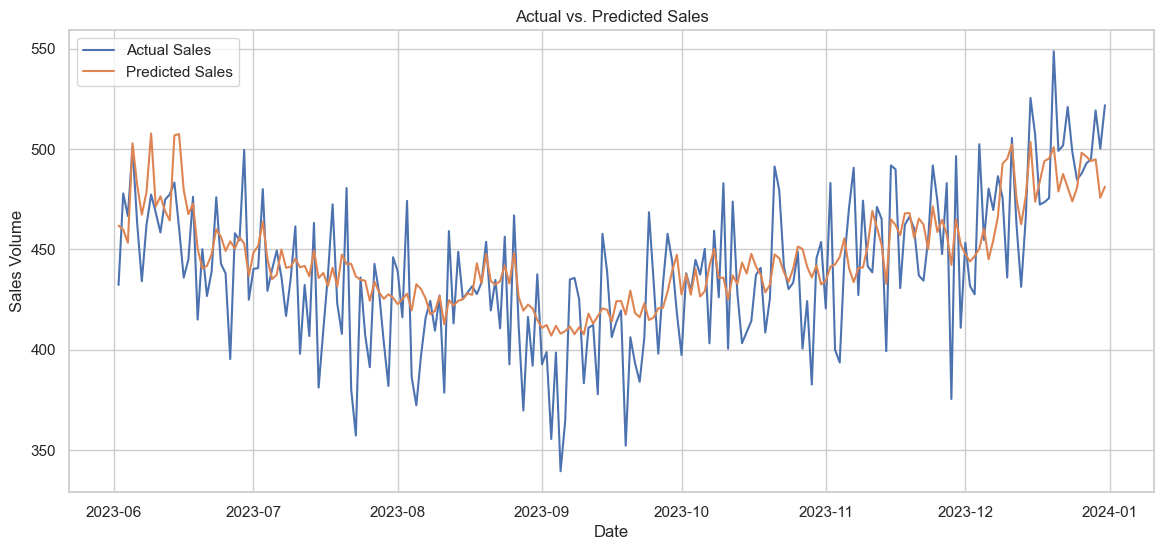

In [19]:
# Actual vs. Predicted Sales Plot
plt.figure(figsize=(14, 6))
plt.plot(data['Date'].iloc[train_size:], y_test, label='Actual Sales')
plt.plot(data['Date'].iloc[train_size:], y_pred, label='Predicted Sales')
plt.title('Actual vs. Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.show()

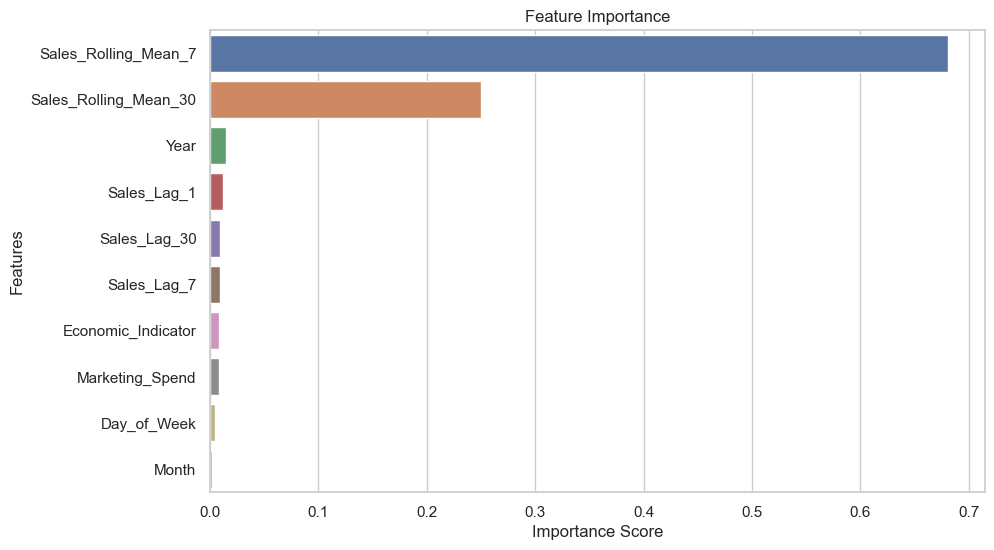

In [20]:
# Feature Importance (i.e. how much each feature contributes to the model)
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


6. Sales Forecasting
----------------------

To forecast future sales, we'll assume we have the necessary features.
For simplicity, we'll forecast the next 30 days based on the last available data we created.

In [21]:
#Create a DataFrame to hold future dates
future_days = 30
last_date = data['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='D')

# Initialize future DataFrame
future_data = pd.DataFrame({'Date': future_dates})

# Feature Engineering for Future Data
future_data['Day_of_Week'] = future_data['Date'].dt.dayofweek
future_data['Month'] = future_data['Date'].dt.month
future_data['Year'] = future_data['Date'].dt.year

# Assume Marketing Spend and Economic Indicator trends
# For simplicity, we'll use the last known value or apply a simple trend
future_data['Marketing_Spend'] = data['Marketing_Spend'].iloc[-1] + np.random.normal(0, 100, future_days)
future_data['Economic_Indicator'] = data['Economic_Indicator'].iloc[-1] + np.random.normal(0, 1, future_days)


In [22]:
# Generate Lag Features using the last available data
for lag in [1, 7, 30]:
    lag_values = np.pad(data['Sales'].iloc[-lag:].values, (0, future_days - lag), 'constant', constant_values=(0))
    future_data[f'Sales_Lag_{lag}'] = lag_values

# Rolling Mean Features
rolling_mean_7 = data['Sales'].rolling(window=7).mean().iloc[-future_days:]
future_data['Sales_Rolling_Mean_7'] = np.pad(rolling_mean_7, (0, future_days - len(rolling_mean_7)), 'constant', constant_values=(0))

rolling_mean_30 = data['Sales'].rolling(window=30).mean().iloc[-future_days:]
future_data['Sales_Rolling_Mean_30'] = np.pad(rolling_mean_30, (0, future_days - len(rolling_mean_30)), 'constant', constant_values=(0))


In [23]:
# Make Predictions for Future Sales
predictions = []
last_known_sales = data['Sales'].iloc[-1]
last_7_sales = data['Sales'].iloc[-7:].tolist()
last_30_sales = data['Sales'].iloc[-30:].tolist()

for i in range(future_days):
    # Update lag features
    future_data.loc[i, 'Sales_Lag_1'] = last_known_sales
    future_data.loc[i, 'Sales_Lag_7'] = last_7_sales[-7]
    future_data.loc[i, 'Sales_Lag_30'] = last_30_sales[-30]
    
    # Update rolling means
    future_data.loc[i, 'Sales_Rolling_Mean_7'] = np.mean(last_7_sales[-6:] + [last_known_sales])
    future_data.loc[i, 'Sales_Rolling_Mean_30'] = np.mean(last_30_sales[-29:] + [last_known_sales])
    
    # Select features
    future_features = future_data.loc[i, features].values.reshape(1, -1)
    
    # Predict sales
    pred_sale = model.predict(future_features)[0]
    predictions.append(pred_sale)
    
    # Update sales lists
    last_known_sales = pred_sale
    last_7_sales.append(pred_sale)
    last_30_sales.append(pred_sale)


/Users/zach/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/zach/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/zach/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/zach/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/zach/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/zach/anaconda3/lib

In [24]:
# Add predictions to future_data
future_data['Predicted_Sales'] = predictions

# Combine with historical data for visualization
combined_data = pd.concat([data[['Date', 'Sales']], 
                           future_data[['Date', 'Predicted_Sales']].rename(columns={'Predicted_Sales': 'Sales'})], 
                          ignore_index=True)


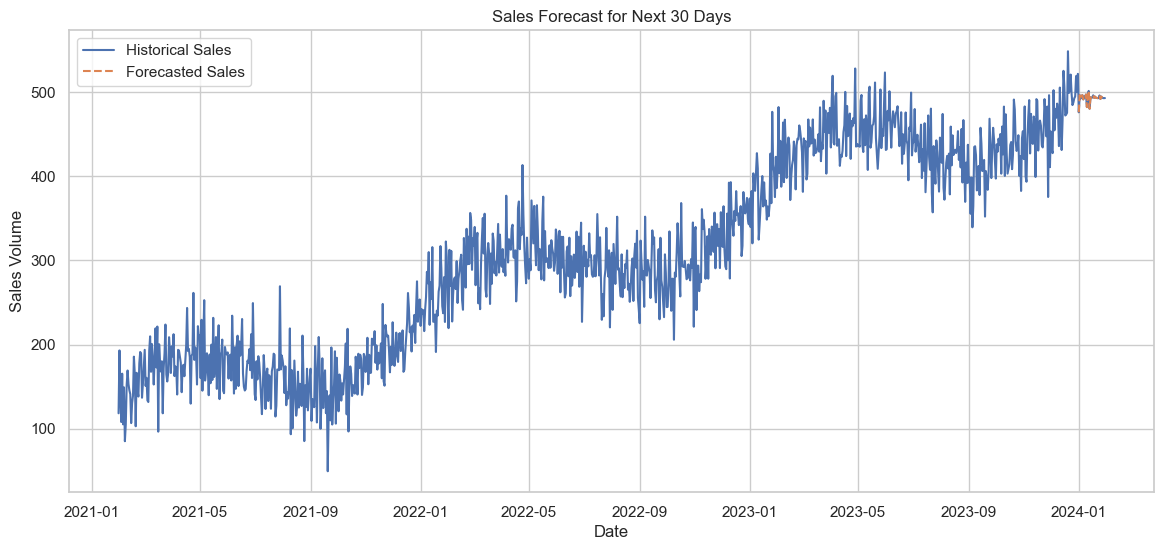

In [25]:
# Plot Forecasted Sales
plt.figure(figsize=(14, 6))
plt.plot(combined_data['Date'], combined_data['Sales'], label='Historical Sales')
plt.plot(future_data['Date'], future_data['Predicted_Sales'], label='Forecasted Sales', linestyle='--')
plt.title('Sales Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.show()

7. Conclusion
--------------

**Sales Forecasting Model Summary:**

Here is basic Summary of Sales Forecasting Approach
- **Model Used**: Random Forest Regressor
- **Training Data Size**: 852 samples
- **Testing Data Size**: 213 samples
- **Performance Metrics**:
    - Mean Absolute Error (MAE): 22.03
    - Root Mean Squared Error (RMSE): 27.50

**Insights:**
- The model captures the underlying patterns in sales data influenced by marketing spend and economic indicators.
- The rolling averages are a significant indicators of sales volume.
- Seasonality and trend components are effectively modeled through feature engineering.

**Forecasting:**
- The model forecasts a slight stagnation trend in sales over the next 30 days.
- It's crucial to regularly update the model with new data, especially to use real-world data, to maintain accuracy.

**Next Steps I would recommend if used for a Real-World Sales Aplication:**
- **Data Collection**: Use actual sales data from the company, including more granular features.
- **Advanced Models**: Experiment with time series-specific models like ARIMA, SARIMA, or Prophet. Use these models as extra data and compare to the above Random Forrest Model
- **Feature Enhancement**: Incorporate additional features such as competitor pricing, holiday/quartly fluctuations, or promotional events.
- **Model Tuning**: Optimize hyperparameters using techniques like Grid Search or Random Search.
- **Deployment**: Develop a pipeline for automated data ingestion, model retraining, and forecasting.


